In [58]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
import galsim
from pyHalo.preset_models import CDM
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf

In [59]:
ps_dir = os.path.join(array_dir, 'power_spectra')

In [60]:
r = np.load(os.path.join(ps_dir, 'r.npy'))
kappa_r = np.load(os.path.join(ps_dir, 'kappa_r.npy'))

images = [np.load(i) for i in glob(os.path.join(ps_dir, 'im_subs_*.npy'))]
kappa_images = [np.load(i) for i in glob(os.path.join(ps_dir, 'kappa_im_*.npy'))]

In [61]:
power_list_no_subhalos = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_subs_lens_*_no_subhalos_*.npy'))]
power_list_cut_6 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_subs_lens_*_cut_6_*.npy'))]
power_list_cut_7 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_subs_lens_*_cut_7_*.npy'))]
power_list_cut_8 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_subs_lens_*_cut_8_*.npy'))]

stack_no_subhalos = np.vstack(power_list_no_subhalos)
stack_list_cut_6 = np.vstack(power_list_cut_6)
stack_list_cut_7 = np.vstack(power_list_cut_7)
stack_list_cut_8 = np.vstack(power_list_cut_8)

In [62]:
# power_list_no_subhalos_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_no_subhalos.npy'))]
# power_list_cut_6_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_6.npy'))]
# power_list_cut_7_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_7.npy'))]
# power_list_cut_8_kappa = [np.load(i) for i in glob(os.path.join(ps_dir, f'kappa_ps_*_cut_8.npy'))]

# stack_no_subhalos_kappa = np.vstack(power_list_no_subhalos_kappa)
# stack_list_cut_6_kappa = np.vstack(power_list_cut_6_kappa)
# stack_list_cut_7_kappa = np.vstack(power_list_cut_7_kappa)
# stack_list_cut_8_kappa = np.vstack(power_list_cut_8_kappa)

In [63]:
# plt.plot(r, np.mean(stack_list_cut_8, axis=0), label='$\geq 10^8$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_7, axis=0), label='$\geq 10^7$ M$_\odot$')
# plt.plot(r, np.mean(stack_list_cut_6, axis=0), label='$\geq 10^6$ M$_\odot$')
# plt.plot(r, np.mean(stack_no_subhalos, axis=0), label='No subhalos')
# plt.xscale('log')
# plt.legend()
# plt.show()

In [64]:
res_8 = np.mean(stack_list_cut_8, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_7 = np.mean(stack_list_cut_7, axis=0) - np.mean(stack_no_subhalos, axis=0)
res_6 = np.mean(stack_list_cut_6, axis=0) - np.mean(stack_no_subhalos, axis=0)

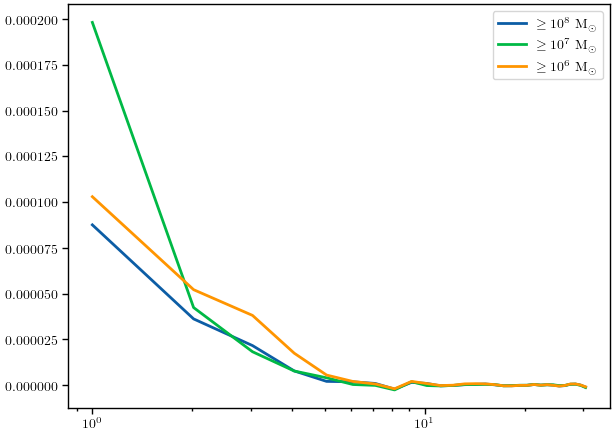

In [65]:
plt.plot(r, res_8, label='$\geq 10^8$ M$_\odot$')
plt.plot(r, res_7, label='$\geq 10^7$ M$_\odot$')
plt.plot(r, res_6, label='$\geq 10^6$ M$_\odot$')
plt.xscale('log')
plt.legend()
plt.show()

In [66]:
res_8_kappa = np.mean(stack_list_cut_8_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
res_7_kappa = np.mean(stack_list_cut_7_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)
res_6_kappa = np.mean(stack_list_cut_6_kappa, axis=0) - np.mean(stack_no_subhalos_kappa, axis=0)

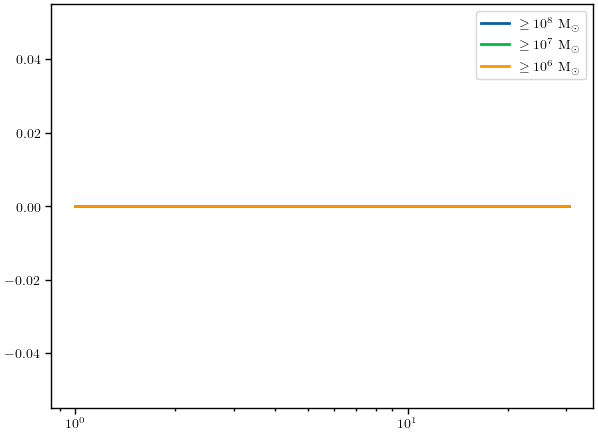

In [67]:
plt.plot(r, res_8_kappa, label='$\geq 10^8$ M$_\odot$')
plt.plot(r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
plt.plot(r, res_6_kappa, label='$\geq 10^6$ M$_\odot$')
plt.xscale('log')
plt.legend()
plt.show()

In [68]:
power_list_nominal = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_lens_*_no_subhalos_*_4.npy'))]
power_list_1 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_lens_*_cut_6_*_1.npy'))]
power_list_9 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_lens_*_cut_7_*_9.npy'))]
power_list_17 = [np.load(i) for i in glob(os.path.join(ps_dir, f'ps_lens_*_cut_8_*_17.npy'))]

stack_nominal = np.vstack(power_list_nominal)
stack_list_1 = np.vstack(power_list_1)
stack_list_9 = np.vstack(power_list_9)
stack_list_17 = np.vstack(power_list_17)

In [69]:
dif_1 = np.mean(stack_list_1, axis=0) - np.mean(stack_nominal, axis=0)
dif_9 = np.mean(stack_list_9, axis=0) - np.mean(stack_nominal, axis=0)
dif_17 = np.mean(stack_list_17, axis=0) - np.mean(stack_nominal, axis=0)

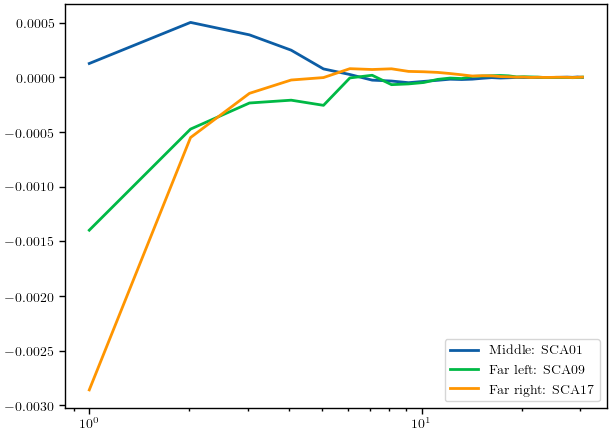

In [70]:
plt.plot(r, dif_1, label='Middle: SCA01')
plt.plot(r, dif_9, label='Far left: SCA09')
plt.plot(r, dif_17, label='Far right: SCA17')
plt.xscale('log')
plt.legend()
plt.show()

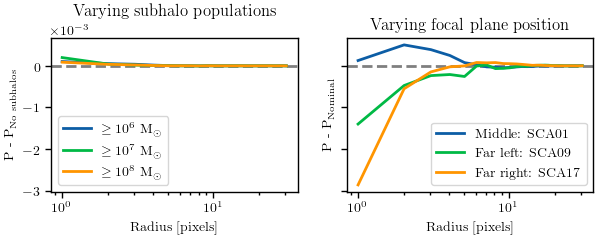

In [71]:
f, ax = plt.subplots(1, 2, figsize=(7, 2), sharey=True)

# ax.plot(r, flat_ps, label='flat')
# ax.plot(r, ps_no_subhalos, label='No subhalos')
ax[0].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[0].plot(r, res_6, label='$\geq 10^6$ M$_\odot$')
ax[0].plot(r, res_7, label='$\geq 10^7$ M$_\odot$')
ax[0].plot(r, res_8, label='$\geq 10^8$ M$_\odot$')
ax[0].set_xscale('log')
ax[0].set_xlabel('Radius [pixels]')
ax[0].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
ax[0].legend()
ax[0].set_title('Varying subhalo populations')

ax[1].axhline(0, color='black', linestyle='--', alpha=0.5)
ax[1].plot(r, dif_1, label='Middle: SCA01')
ax[1].plot(r, dif_9, label='Far left: SCA09')
ax[1].plot(r, dif_17, label='Far right: SCA17')
ax[1].set_xscale('log')
ax[1].set_xlabel('Radius [pixels]')
ax[1].set_ylabel(r'P - P$_{\textrm{Nominal}}$')
ax[1].legend()
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[1].set_title('Varying focal plane position')

# ax[2].axhline(0, color='black', linestyle='--', alpha=0.5)
# ax[2].plot(kappa_r, res_8_kappa, label='$\geq 10^6$ M$_\odot$')
# ax[2].plot(kappa_r, res_7_kappa, label='$\geq 10^7$ M$_\odot$')
# ax[2].plot(kappa_r, res_6_kappa, label='$\geq 10^8$ M$_\odot$')
# ax[2].set_xscale('log')
# ax[2].set_xlabel('Radius [pixels]')
# ax[2].set_ylabel(r'P - P$_{\textrm{No subhalos}}$')
# ax[2].legend()
# ax[2].set_title('Convergence maps')

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'))
plt.show()